#  Install and import required libraries.

In [1]:
!pip install -q timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.8 MB/s eta 0:00:00


In [2]:
import os
import math

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import cv2
import albumentations
import timm
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score

# Prepare Dataset.

## Download and unzip downloaded file.

In [3]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2024-08-25 22:11:47--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2024-08-25 22:11:47--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  24.1MB/s    in 7.8s    

2024-08-25 22:11:54 (30.5 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [4]:
!unzip tiny-imagenet-200.zip >> out.txt

## Class for our dataset.

In [5]:
class TinyINDataset(torch.utils.data.Dataset):
    """
    Dataset has two lists. One list contains paths to all images in dataset.
    The other contains respective class order.
    """
    def __init__(self, path, classes, transform, dataset_type):
        #allowed dataset type can be only 'train' or 'val'
        assert dataset_type in ['train', 'val'], 'Dataset can have two allowed type: train or val'
        #a dict with key - class name and value - its respective order
        class_to_int = {cls:i for i, cls in enumerate(classes)}
        #paths to all images in dataset
        self.images_paths = []
        #respective class order of image
        self.labels = []

        if dataset_type == 'train':
          for cls in os.listdir(path):
            images_names = os.listdir(os.path.join(path, cls, 'images'))
            self.images_paths.extend([os.path.join(path, cls, 'images', image_name) for image_name in images_names])
            self.labels.extend([class_to_int[cls] for _ in range(len(images_names))])
        else:
          images_names = os.listdir(os.path.join(path, 'images'))
          self.images_paths = [os.path.join(path, 'images', image_name) for image_name in images_names]
          df = pd.read_csv(os.path.join(path, 'val_annotations.txt'), sep='\t', header=None)
          df = df[[0,1]]
          image_name_to_class = {image_name: cls for image_name, cls in zip(df.values[:,0], df.values[:,1])}
          self.labels = [class_to_int[image_name_to_class[image_name]] for image_name in images_names]

        self.transform = transform

    def __getitem__(self, idx):
        image = cv2.imread(self.images_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #we do resize (if necessary) in transform
        if self.transform is not None:
            image = self.transform(image=image)["image"]

        label = self.labels[idx]

        return image, torch.tensor(label)

    def __len__(self):
        return len(self.images_paths)

## Data Augmentation.
All images in Tiny ImageNet have commom fixable size  64x64 so we don't need to resize or crop our images.

In [6]:
train_transform = albumentations.Compose(
    [
        albumentations.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        # albumentations.RandomCrop(height=256, width=256),
        albumentations.RGBShift(r_shift_limit=5, g_shift_limit=5, b_shift_limit=5, p=0.5),
        albumentations.RandomBrightnessContrast(p=0.5),
        albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

val_transform = albumentations.Compose(
    [
        # albumentations.CenterCrop(height=256, width=256),
        albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

## Create train and validation dataset.

In [7]:
classes = sorted(os.listdir('tiny-imagenet-200/train/'))
train_dataset = TinyINDataset('tiny-imagenet-200/train', classes, train_transform, 'train')
val_dataset = TinyINDataset('tiny-imagenet-200/val', classes, train_transform, 'val')

# Create our model.

# Class for our model.


In [8]:
class MyModel(torch.nn.Module):
  def __init__(
          self,
          model_name: str,
          pretrained: bool,
          exportable: bool,
          num_classes: int,
          global_pool: str,
    ) -> None:

    super().__init__()
    #create model from timm
    self._backbone = timm.create_model(
      model_name=model_name,
      pretrained=pretrained,
      exportable=exportable,
      num_classes=num_classes,
      global_pool=global_pool,
    )
    in_features = self._backbone.get_classifier().in_features
    #remove old head (fully connnected layers) from model
    self._backbone.reset_classifier(num_classes=0)
    #add new head
    self.fc_head = torch.nn.Sequential(
        torch.nn.Linear(in_features, 512),
        torch.nn.BatchNorm1d(512),
        torch.nn.ReLU(inplace=True),

        torch.nn.Linear(512, 512),
        torch.nn.BatchNorm1d(512),
        torch.nn.ReLU(inplace=True),

        torch.nn.Linear(512, num_classes),
    )

  def forward(self, tensor: torch.Tensor) -> torch.Tensor:
    return self.fc_head(self._backbone(tensor))

## Create model and move it to GPU.

In [9]:
model = MyModel('resnet50.a1_in1k', pretrained=True, exportable=True,  num_classes=200, global_pool='avg')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [10]:
model.cuda()
model(torch.rand(2,3,64,64).cuda()).shape

torch.Size([2, 200])

# Training Process.

## Create dataloaders, loss function and optimizer.

In [11]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    pin_memory=True,
    num_workers=2,
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    pin_memory=True,
    num_workers=2
)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

## Training loop.

In [13]:
epochs = 10
epoch_iter = 0
#buffer to save losses across training process
losses_buffer = []
#buffer to save accuracy in val_dataset after every epoch
accuracy_buffer = []
acc = 0
total = len(train_dataset)/32 if len(train_dataset)%32 == 0 else math.floor(len(train_dataset)/32)+1
while epoch_iter <= epochs and acc < 0.8:
    model.train()
    for j, (x, y) in tqdm(enumerate(train_loader), total=total):
        optimizer.zero_grad(set_to_none = True)
        x = x.cuda(non_blocking = True)
        y = y.cuda(non_blocking = True)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        if j%500 == 0:
            print(f"Epoch {epoch_iter:3}\t iter {j:3}\t loss {loss:1.4}")
            losses_buffer.append(loss.cpu().detach().numpy())

    model.eval()
    y_preds = []
    y_trues = []
    with torch.no_grad():
        for j, (x, y) in enumerate(val_loader):
            x = x.cuda(non_blocking = True)
            y = y.cuda(non_blocking = True)
            y_pred = model(x)
            y_trues.extend(y.tolist())
            y_preds.extend(y_pred.argmax(dim=1).tolist())
    acc = accuracy_score(y_true = y_trues, y_pred = y_preds)
    accuracy_buffer.append(acc)
    print(f"Epoch {epoch_iter:3}\t val_acc {acc:1.4}")

    epoch_iter += 1

  0%|          | 3/3125.0 [00:00<12:36,  4.13it/s]

Epoch   0	 iter   0	 loss 5.459


 16%|█▌        | 503/3125.0 [00:30<02:16, 19.21it/s]

Epoch   0	 iter 500	 loss 4.532


 32%|███▏      | 1005/3125.0 [00:59<01:47, 19.80it/s]

Epoch   0	 iter 1000	 loss 3.788


 48%|████▊     | 1503/3125.0 [01:30<01:26, 18.82it/s]

Epoch   0	 iter 1500	 loss 3.397


 64%|██████▍   | 2005/3125.0 [01:59<00:56, 19.73it/s]

Epoch   0	 iter 2000	 loss 2.68


 80%|████████  | 2503/3125.0 [02:27<00:51, 12.03it/s]

Epoch   0	 iter 2500	 loss 3.054


 96%|█████████▌| 3004/3125.0 [02:55<00:08, 14.24it/s]

Epoch   0	 iter 3000	 loss 2.489


100%|██████████| 3125/3125.0 [03:03<00:00, 17.05it/s]


Epoch   0	 val_acc 0.5225


  0%|          | 3/3125.0 [00:00<05:58,  8.70it/s]

Epoch   1	 iter   0	 loss 2.311


 16%|█▌        | 503/3125.0 [00:27<03:26, 12.71it/s]

Epoch   1	 iter 500	 loss 2.433


 32%|███▏      | 1003/3125.0 [00:56<01:47, 19.69it/s]

Epoch   1	 iter 1000	 loss 2.243


 48%|████▊     | 1504/3125.0 [01:25<01:21, 19.95it/s]

Epoch   1	 iter 1500	 loss 2.033


 64%|██████▍   | 2004/3125.0 [01:53<00:56, 19.83it/s]

Epoch   1	 iter 2000	 loss 1.981


 80%|████████  | 2505/3125.0 [02:22<00:30, 20.51it/s]

Epoch   1	 iter 2500	 loss 1.746


 96%|█████████▌| 3004/3125.0 [02:52<00:07, 16.49it/s]

Epoch   1	 iter 3000	 loss 1.174


100%|██████████| 3125/3125.0 [02:58<00:00, 17.46it/s]


Epoch   1	 val_acc 0.5983


  0%|          | 4/3125.0 [00:00<03:46, 13.79it/s]

Epoch   2	 iter   0	 loss 2.243


 16%|█▌        | 504/3125.0 [00:30<02:16, 19.24it/s]

Epoch   2	 iter 500	 loss 2.074


 32%|███▏      | 1003/3125.0 [00:58<01:44, 20.32it/s]

Epoch   2	 iter 1000	 loss 1.659


 48%|████▊     | 1502/3125.0 [01:26<02:12, 12.25it/s]

Epoch   2	 iter 1500	 loss 1.479


 64%|██████▍   | 2002/3125.0 [01:54<01:21, 13.84it/s]

Epoch   2	 iter 2000	 loss 1.435


 80%|████████  | 2504/3125.0 [02:22<00:31, 19.83it/s]

Epoch   2	 iter 2500	 loss 1.762


 96%|█████████▌| 3003/3125.0 [02:51<00:06, 19.19it/s]

Epoch   2	 iter 3000	 loss 1.347


100%|██████████| 3125/3125.0 [02:58<00:00, 17.48it/s]


Epoch   2	 val_acc 0.6154


  0%|          | 3/3125.0 [00:00<04:17, 12.11it/s]

Epoch   3	 iter   0	 loss 1.739


 16%|█▌        | 503/3125.0 [00:29<02:17, 19.09it/s]

Epoch   3	 iter 500	 loss 1.58


 32%|███▏      | 1004/3125.0 [00:58<01:45, 20.10it/s]

Epoch   3	 iter 1000	 loss 1.746


 48%|████▊     | 1505/3125.0 [01:27<01:21, 19.79it/s]

Epoch   3	 iter 1500	 loss 1.596


 64%|██████▍   | 2004/3125.0 [01:56<00:56, 19.91it/s]

Epoch   3	 iter 2000	 loss 1.506


 80%|████████  | 2503/3125.0 [02:24<00:44, 14.11it/s]

Epoch   3	 iter 2500	 loss 1.446


 96%|█████████▌| 3002/3125.0 [02:51<00:09, 13.22it/s]

Epoch   3	 iter 3000	 loss 1.387


100%|██████████| 3125/3125.0 [02:58<00:00, 17.49it/s]


Epoch   3	 val_acc 0.6286


  0%|          | 3/3125.0 [00:00<04:11, 12.41it/s]

Epoch   4	 iter   0	 loss 1.172


 16%|█▌        | 503/3125.0 [00:28<03:33, 12.28it/s]

Epoch   4	 iter 500	 loss 1.88


 32%|███▏      | 1004/3125.0 [00:55<01:42, 20.62it/s]

Epoch   4	 iter 1000	 loss 1.021


 48%|████▊     | 1503/3125.0 [01:24<01:21, 20.02it/s]

Epoch   4	 iter 1500	 loss 1.143


 64%|██████▍   | 2003/3125.0 [01:54<01:00, 18.46it/s]

Epoch   4	 iter 2000	 loss 1.324


 80%|████████  | 2504/3125.0 [02:24<00:31, 19.88it/s]

Epoch   4	 iter 2500	 loss 1.552


 96%|█████████▌| 3003/3125.0 [02:53<00:06, 20.00it/s]

Epoch   4	 iter 3000	 loss 1.271


100%|██████████| 3125/3125.0 [02:59<00:00, 17.37it/s]


Epoch   4	 val_acc 0.6374


  0%|          | 4/3125.0 [00:00<03:45, 13.86it/s]

Epoch   5	 iter   0	 loss 0.925


 16%|█▌        | 503/3125.0 [00:29<02:10, 20.15it/s]

Epoch   5	 iter 500	 loss 1.406


 32%|███▏      | 1004/3125.0 [00:58<01:58, 17.85it/s]

Epoch   5	 iter 1000	 loss 1.255


 48%|████▊     | 1502/3125.0 [01:26<02:18, 11.76it/s]

Epoch   5	 iter 1500	 loss 1.414


 64%|██████▍   | 2002/3125.0 [01:54<01:20, 13.96it/s]

Epoch   5	 iter 2000	 loss 1.604


 80%|████████  | 2503/3125.0 [02:23<00:31, 19.44it/s]

Epoch   5	 iter 2500	 loss 1.712


 96%|█████████▌| 3004/3125.0 [02:52<00:06, 19.04it/s]

Epoch   5	 iter 3000	 loss 0.9392


100%|██████████| 3125/3125.0 [03:00<00:00, 17.27it/s]


Epoch   5	 val_acc 0.6435


  0%|          | 3/3125.0 [00:00<06:26,  8.07it/s]

Epoch   6	 iter   0	 loss 0.9925


 16%|█▌        | 503/3125.0 [00:29<02:21, 18.48it/s]

Epoch   6	 iter 500	 loss 1.023


 32%|███▏      | 1004/3125.0 [00:59<01:48, 19.57it/s]

Epoch   6	 iter 1000	 loss 1.495


 48%|████▊     | 1504/3125.0 [01:29<01:20, 20.20it/s]

Epoch   6	 iter 1500	 loss 1.074


 64%|██████▍   | 2004/3125.0 [01:58<00:58, 19.28it/s]

Epoch   6	 iter 2000	 loss 1.572


 80%|████████  | 2503/3125.0 [02:27<00:33, 18.78it/s]

Epoch   6	 iter 2500	 loss 1.223


 96%|█████████▌| 3003/3125.0 [02:56<00:07, 17.29it/s]

Epoch   6	 iter 3000	 loss 0.8616


100%|██████████| 3125/3125.0 [03:02<00:00, 17.08it/s]


Epoch   6	 val_acc 0.6479


  0%|          | 3/3125.0 [00:00<04:27, 11.66it/s]

Epoch   7	 iter   0	 loss 1.095


 16%|█▌        | 505/3125.0 [00:29<02:10, 20.01it/s]

Epoch   7	 iter 500	 loss 1.374


 32%|███▏      | 1002/3125.0 [00:58<03:03, 11.59it/s]

Epoch   7	 iter 1000	 loss 1.574


 48%|████▊     | 1503/3125.0 [01:27<02:07, 12.71it/s]

Epoch   7	 iter 1500	 loss 0.6506


 64%|██████▍   | 2004/3125.0 [01:55<00:57, 19.59it/s]

Epoch   7	 iter 2000	 loss 0.9593


 80%|████████  | 2504/3125.0 [02:25<00:32, 19.11it/s]

Epoch   7	 iter 2500	 loss 0.5343


 96%|█████████▌| 3003/3125.0 [02:54<00:06, 19.48it/s]

Epoch   7	 iter 3000	 loss 0.9864


100%|██████████| 3125/3125.0 [03:02<00:00, 17.15it/s]


Epoch   7	 val_acc 0.6535


  0%|          | 3/3125.0 [00:00<04:10, 12.47it/s]

Epoch   8	 iter   0	 loss 1.014


 16%|█▌        | 505/3125.0 [00:29<02:13, 19.69it/s]

Epoch   8	 iter 500	 loss 0.7536


 32%|███▏      | 1005/3125.0 [01:10<01:46, 19.96it/s]

Epoch   8	 iter 1000	 loss 1.175


 48%|████▊     | 1502/3125.0 [01:38<02:18, 11.74it/s]

Epoch   8	 iter 1500	 loss 0.8382


 64%|██████▍   | 2003/3125.0 [02:04<01:08, 16.39it/s]

Epoch   8	 iter 2000	 loss 1.108


 80%|████████  | 2504/3125.0 [02:32<00:30, 20.47it/s]

Epoch   8	 iter 2500	 loss 1.214


 96%|█████████▌| 3005/3125.0 [03:00<00:05, 20.73it/s]

Epoch   8	 iter 3000	 loss 1.008


100%|██████████| 3125/3125.0 [03:06<00:00, 16.72it/s]


Epoch   8	 val_acc 0.6544


  0%|          | 4/3125.0 [00:00<03:42, 14.03it/s]

Epoch   9	 iter   0	 loss 0.7611


 16%|█▌        | 504/3125.0 [00:28<02:06, 20.67it/s]

Epoch   9	 iter 500	 loss 0.4225


 32%|███▏      | 1005/3125.0 [00:56<01:42, 20.73it/s]

Epoch   9	 iter 1000	 loss 0.5712


 48%|████▊     | 1503/3125.0 [01:23<02:07, 12.71it/s]

Epoch   9	 iter 1500	 loss 0.9383


 64%|██████▍   | 2003/3125.0 [01:49<01:01, 18.17it/s]

Epoch   9	 iter 2000	 loss 0.7938


 80%|████████  | 2505/3125.0 [02:17<00:30, 20.28it/s]

Epoch   9	 iter 2500	 loss 0.6615


 96%|█████████▌| 3005/3125.0 [02:44<00:05, 20.73it/s]

Epoch   9	 iter 3000	 loss 0.7168


100%|██████████| 3125/3125.0 [02:50<00:00, 18.29it/s]


Epoch   9	 val_acc 0.6593


  0%|          | 4/3125.0 [00:00<03:53, 13.36it/s]

Epoch  10	 iter   0	 loss 1.064


 16%|█▌        | 503/3125.0 [00:29<02:20, 18.61it/s]

Epoch  10	 iter 500	 loss 0.3238


 32%|███▏      | 1004/3125.0 [00:57<01:42, 20.74it/s]

Epoch  10	 iter 1000	 loss 0.9425


 48%|████▊     | 1505/3125.0 [01:25<01:23, 19.36it/s]

Epoch  10	 iter 1500	 loss 0.8375


 64%|██████▍   | 2002/3125.0 [01:54<01:33, 11.99it/s]

Epoch  10	 iter 2000	 loss 0.5456


 80%|████████  | 2503/3125.0 [02:21<00:36, 16.98it/s]

Epoch  10	 iter 2500	 loss 0.5871


 96%|█████████▌| 3003/3125.0 [02:50<00:06, 18.83it/s]

Epoch  10	 iter 3000	 loss 0.8661


100%|██████████| 3125/3125.0 [02:58<00:00, 17.51it/s]


Epoch  10	 val_acc 0.6573


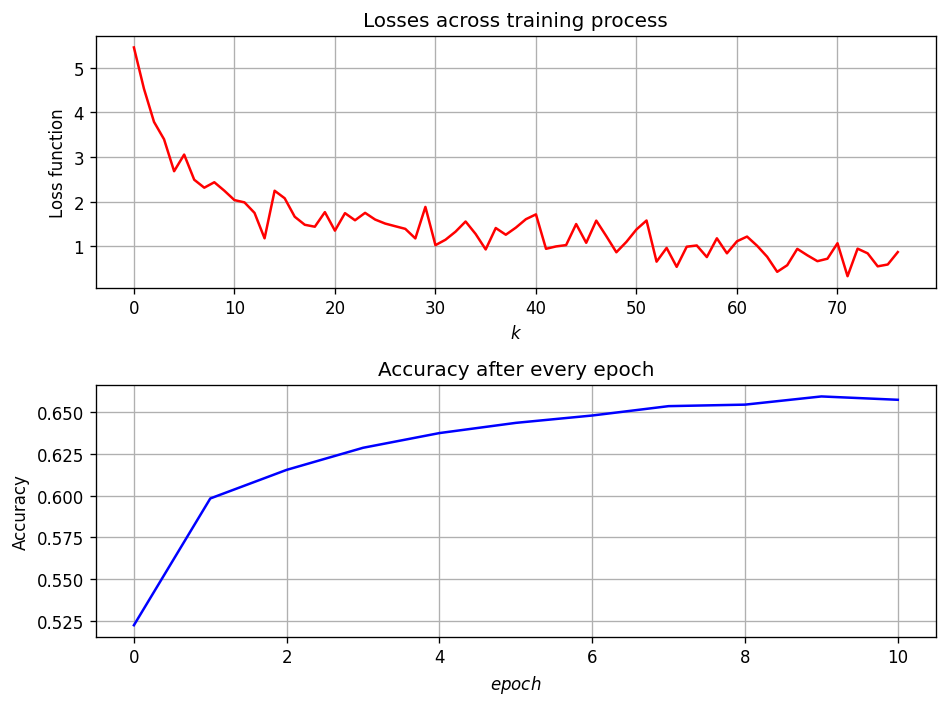

In [14]:
fig, axs = plt.subplots(2, 1, figsize=[8, 6], dpi = 120)

axs[0].plot(np.arange(len(losses_buffer)), losses_buffer, color='red')
axs[0].set_xlabel("$k$")
axs[0].set_ylabel("Loss function")
axs[0].set_title("Losses across training process")
axs[0].grid()

axs[1].plot(np.arange(len(accuracy_buffer)), accuracy_buffer, color='blue')
axs[1].set_xlabel("$epoch$")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Accuracy after every epoch")
axs[1].grid()

fig.tight_layout()
plt.show()

# Save trained model.

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model_state_dict.pth')